# 拼圖活動期望值計算
***
* 確認目前活動所需拼圖數，以及如何調整
* 共20層，每層需9片，出現位置的機率都一樣，若同層出現多片，下一層可沿用
* 直接採蒙地卡羅計算

## 1. 原方案
***

In [13]:
import random
import numpy as np
import pandas as pd
from scipy import stats
%matplotlib inline
import matplotlib as mpl  #套件頂層
from matplotlib import pyplot as plt
import seaborn as sns         #進階繪圖配置
sns.set()
# plt.style.use('classic')
mpl.rcParams['font.family'] = ['Noto Sans CJK TC']  #指定字型  以後可以使用中文

In [29]:
def simulate_holes(num_holes = 9, balls_per_hole = 20):
    """定義一個模擬實驗，有9個洞，目標需有20顆球"""
    
    holes = [0] * num_holes     # 初始化9個洞的球數
    num_balls = 0               # 初始化投球次數
    recorded_level_one = False  # 是否紀錄過第1層花費拼圖數
    
    # 當任一個洞沒達到目標球數時，繼續投球
    while min(holes) < balls_per_hole:
        hole = random.randint(0, num_holes - 1)    # 隨機抽1個洞
        holes[hole] += 1                           # 該洞球數 +1
        num_balls += 1
        
        # 紀錄完成第1層的總投球
        if (not recorded_level_one) & (min(holes)>=1):
            num_balls_for_level_one = num_balls
            recorded_level_one = True
        
    return num_balls, num_balls_for_level_one

In [30]:
# 進行模擬
num_simulations = 10000
result_list = []
result_level_one = []
for _ in range(num_simulations):
    num_balls, num_balls_for_level_one = simulate_holes()
    result_list.append(num_balls)
    result_level_one.append(num_balls_for_level_one)

In [31]:
# 計算結果
df = pd.DataFrame({'20層次數': result_list, '第1層次數': result_level_one})
df.describe()

,20層次數,第1層次數
count,10000.000000,10000.000000
mean,243.845800,25.389100
std,25.463901,9.741704
min,187.000000,9.000000
25%,226.000000,18.000000
50%,240.000000,23.000000
75%,258.000000,30.000000
max,387.000000,93.000000


C:\Users\pc053\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\pc053\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, '完成20層拼圖頻次圖')

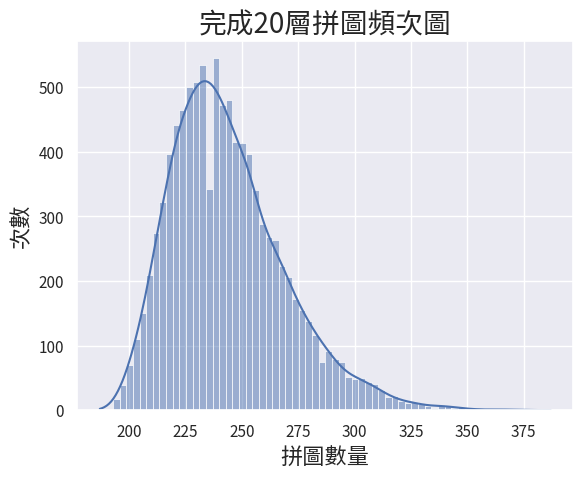

In [32]:
# 繪製頻次圖
sns.histplot(result_list, kde=True)
plt.xlabel('拼圖數量', fontsize=16)
plt.ylabel('次數', fontsize=16)
plt.title('完成20層拼圖頻次圖', fontsize=20)

C:\Users\pc053\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\pc053\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, '完成1層拼圖頻次圖')

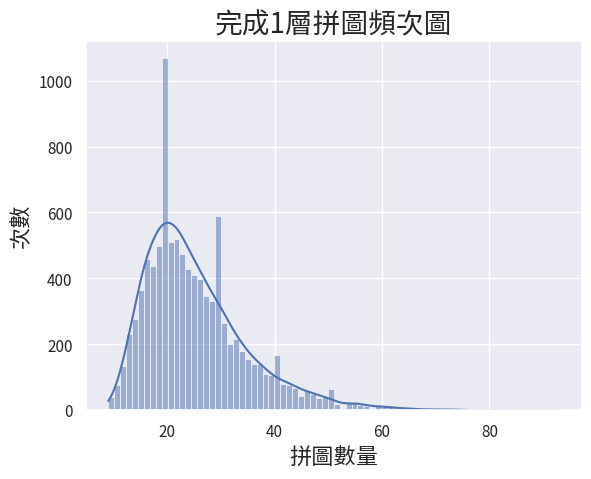

In [33]:
# 繪製頻次圖
sns.histplot(result_level_one, kde=True)
plt.xlabel('拼圖數量', fontsize=16)
plt.ylabel('次數', fontsize=16)
plt.title('完成1層拼圖頻次圖', fontsize=20)

In [34]:
# 20層平均值信賴區間
import scipy.stats as stats

# 假設你有平均值、標準差和樣本大小
mean_value = df.describe().loc['mean'].values[0]
std_dev = df.describe().loc['std'].values[0]
sample_size = len(df)

# 計算 t 分數
t_score = stats.t.ppf(0.975, df=sample_size-1)  # 0.975 是因為是雙尾檢驗，95%信心水準

# 計算信心區間
confidence_interval = stats.t.interval(0.95, df=sample_size-1, loc=mean_value, scale=std_dev/((sample_size)**0.5))

print("95% 信心區間:", confidence_interval)

95% 信心區間: (243.34665628727097, 244.34494371272902)


In [35]:
# 1層平均值信賴區間
import scipy.stats as stats

# 假設你有平均值、標準差和樣本大小
mean_value = df.describe().loc['mean'].values[1]
std_dev = df.describe().loc['std'].values[1]
sample_size = len(df)

# 計算 t 分數
t_score = stats.t.ppf(0.975, df=sample_size-1)  # 0.975 是因為是雙尾檢驗，95%信心水準

# 計算信心區間
confidence_interval = stats.t.interval(0.95, df=sample_size-1, loc=mean_value, scale=std_dev/((sample_size)**0.5))

print("95% 信心區間:", confidence_interval)

95% 信心區間: (25.198143000682048, 25.58005699931795)


## 2. 新方案
***
第N層前，50%機率開到重複的，50%開到沒重複的

In [17]:
def new_simulate_holes(change_stage, prob_for_new_holes, num_holes = 9, balls_per_hole = 20):
    """定義一個模擬實驗，有9個洞，目標需有20顆球，但前N層會採用K機率開到新的"""
    
    holes = [0] * num_holes        # 初始化9個洞的球數
    num_balls = 0                  # 初始化投球次數
    holes_index = list(range(num_holes))   # 建立一個球洞的index
    recorded_level_one = False
    
    # 當關卡 <= 改變關卡時，採用50%規則
    while min(holes) < change_stage:
        
        # 紀錄最少球的索引
        min_index = [i for i, j in enumerate(holes) if j == min(holes)]   
        
        # 若最少球數索引數量比總洞少，才能進行重複不重複判斷，預防全都一樣小的情形
        if len(min_index) < num_holes:
        
            # 決定新洞還舊洞
            random_prob = random.random()              # 生成一個介於 0 到 1 之間的隨機浮點數
            is_new_hole = 1 if random_prob <= prob_for_new_holes else 0    # 若骰出浮點數 < 設定值，則選新洞

            # 若新洞
            if is_new_hole == 1:
                hole = random.choice(min_index)         # 從最小洞抽一個

            # 若舊洞    
            else:
                duplicate_holes = [x for x in holes_index if x not in min_index]    # 從非最小洞抽一個
                hole = random.choice(duplicate_holes)
        
        # 若洞的球都一樣多        
        else:
            hole = random.randint(0, num_holes - 1)    # 隨機抽1個洞
        
        holes[hole] += 1                           # 該洞球數 +1
        num_balls += 1  
        
        # 紀錄完成第1層的總投球
        if (not recorded_level_one) & (min(holes) >= 1):
            num_balls_for_level_one = num_balls
            recorded_level_one = True
        
    # 上面迴圈跑完後，才會跑下面迴圈，當任一個洞沒達到目標球數時，繼續投球
    while min(holes) < balls_per_hole:
        hole = random.randint(0, num_holes - 1)    # 隨機抽1個洞
        holes[hole] += 1                           # 該洞球數 +1
        num_balls += 1
    
    return num_balls, num_balls_for_level_one

In [40]:
# 進行模擬
num_simulations = 10000
result_list = []
result_level_one = []
for _ in range(num_simulations):
    num_balls, num_balls_for_level_one = new_simulate_holes(change_stage=20,            # 前3層改變算法機率
                                                            prob_for_new_holes=0.6     # 前3層新洞的機率為55%
                                                           )
    result_list.append(num_balls)
    result_level_one.append(num_balls_for_level_one)

In [41]:
# 計算結果
df = pd.DataFrame({'20層次數': result_list, '第1層次數': result_level_one})
df.describe()

,20層次數,第1層次數
count,10000.000000,10000.00000
mean,187.360000,14.32490
std,3.713594,2.97066
min,180.000000,9.00000
25%,185.000000,12.00000
50%,187.000000,14.00000
75%,190.000000,16.00000
max,213.000000,29.00000


C:\Users\pc053\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\pc053\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, '完成20層拼圖頻次圖')

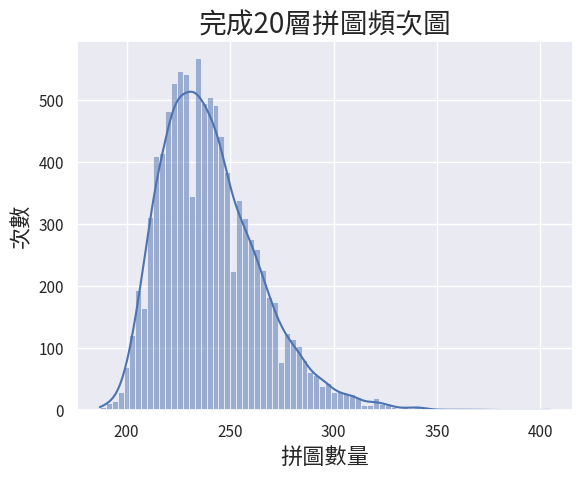

In [32]:
# 繪製頻次圖
sns.histplot(result_list, kde=True)
plt.xlabel('拼圖數量', fontsize=16)
plt.ylabel('次數', fontsize=16)
plt.title('完成20層拼圖頻次圖', fontsize=20)

C:\Users\pc053\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\pc053\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, '完成1層拼圖頻次圖')

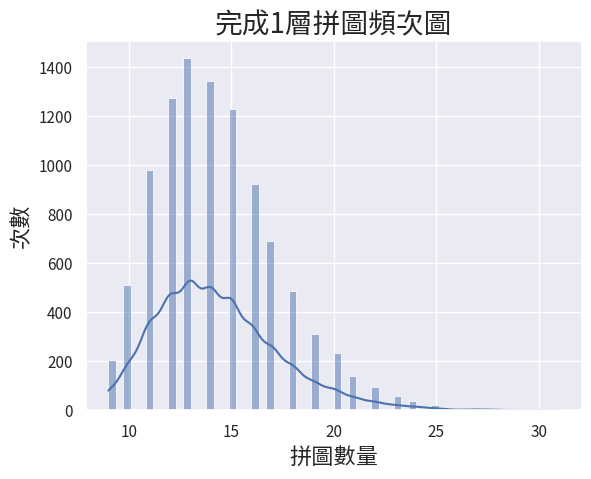

In [33]:
# 繪製頻次圖
sns.histplot(result_level_one, kde=True)
plt.xlabel('拼圖數量', fontsize=16)
plt.ylabel('次數', fontsize=16)
plt.title('完成1層拼圖頻次圖', fontsize=20)

In [41]:
# 20層平均值信賴區間
import scipy.stats as stats

# 假設你有平均值、標準差和樣本大小
mean_value = df.describe().loc['mean'].values[0]
std_dev = df.describe().loc['std'].values[0]
sample_size = len(df)

# 計算 t 分數
t_score = stats.t.ppf(0.975, df=sample_size-1)  # 0.975 是因為是雙尾檢驗，95%信心水準

# 計算信心區間
confidence_interval = stats.t.interval(0.95, df=sample_size-1, loc=mean_value, scale=std_dev/((sample_size)**0.5))

print("95% 信心區間:", confidence_interval)

95% 信心區間: (239.42186604310115, 240.35813395689883)


In [42]:
# 1層平均值信賴區間
import scipy.stats as stats

# 假設你有平均值、標準差和樣本大小
mean_value = df.describe().loc['mean'].values[1]
std_dev = df.describe().loc['std'].values[1]
sample_size = len(df)

# 計算 t 分數
t_score = stats.t.ppf(0.975, df=sample_size-1)  # 0.975 是因為是雙尾檢驗，95%信心水準

# 計算信心區間
confidence_interval = stats.t.interval(0.95, df=sample_size-1, loc=mean_value, scale=std_dev/((sample_size)**0.5))

print("95% 信心區間:", confidence_interval)

95% 信心區間: (16.93451789562962, 17.09248210437038)


## 3. 迴圈模擬
***
第N層前，K%機率開到重複的

In [42]:
# 進行模擬
num_simulations = 10000

# 預測結果
df_results = pd.DataFrame(columns=['change_stage', 'prob_for_new_holes', 'mean_total', 'mean_level_one'])

# 前i層改變
for i in range(1, 11, 1):
    
    # 前i層抽到機率
    for j in np.arange(0.5, 0.8, 0.05):
        
        result_list = []
        result_level_one = []
        for _ in range(num_simulations):
            num_balls, num_balls_for_level_one = new_simulate_holes(change_stage=i,            # 前3層改變算法機率
                                                                    prob_for_new_holes=j       # 前3層新洞的機率
                                                                   )
            result_list.append(num_balls)
            result_level_one.append(num_balls_for_level_one)
            
        # 計算平均值
        mean_total = np.mean(result_list)
        mean_level_one = np.mean(result_level_one)
        
        # 將結果記錄到 DataFrame
        data_to_insert = {'change_stage': i,
                          'prob_for_new_holes': j,
                          'mean_total': mean_total,
                          'mean_level_one': mean_level_one}
        df_results.loc[len(df_results)] = data_to_insert

In [94]:
df_results.head()

,change_stage,prob_for_new_holes,mean_total,mean_level_one
0,1,0.50,241.8847,17.0169
1,1,0.55,242.4674,15.5288
2,1,0.60,241.7903,14.3381
3,1,0.65,241.7963,13.3196
4,1,0.70,241.5871,12.4191


In [102]:
df_results['prob_for_new_holes'].unique()

array([0.5 , 0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 ])

C:\Users\pc053\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\pc053\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\pc053\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


Text(0, 0.5, '花費拼圖')

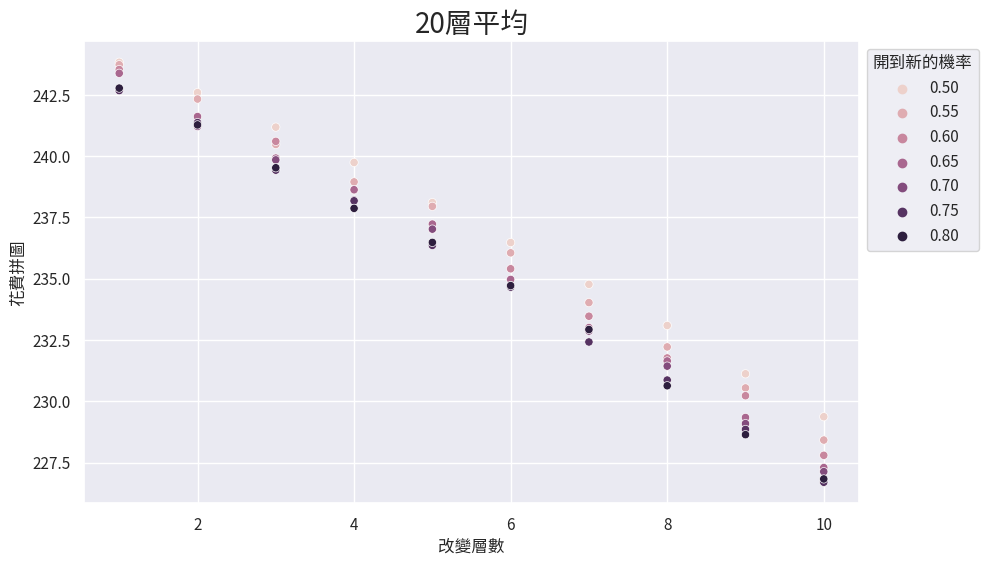

In [46]:
# 繪圖
plt.figure(figsize=(10, 6))
scatter = sns.scatterplot(x = df_results['change_stage'],
                          y = df_results['mean_total'],
                          hue = df_results['prob_for_new_holes'],
                          legend = 'full')


scatter.legend(loc='upper left', bbox_to_anchor=(1, 1), title='開到新的機率')

legend_labels = scatter.get_legend().get_texts()
for label in legend_labels:
    label.set_text(f'{float(label.get_text()):.2f}')

plt.title('20層平均', fontsize=20)
plt.xlabel('改變層數')
plt.ylabel('花費拼圖')

C:\Users\pc053\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\pc053\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\pc053\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


Text(0, 0.5, '花費拼圖')

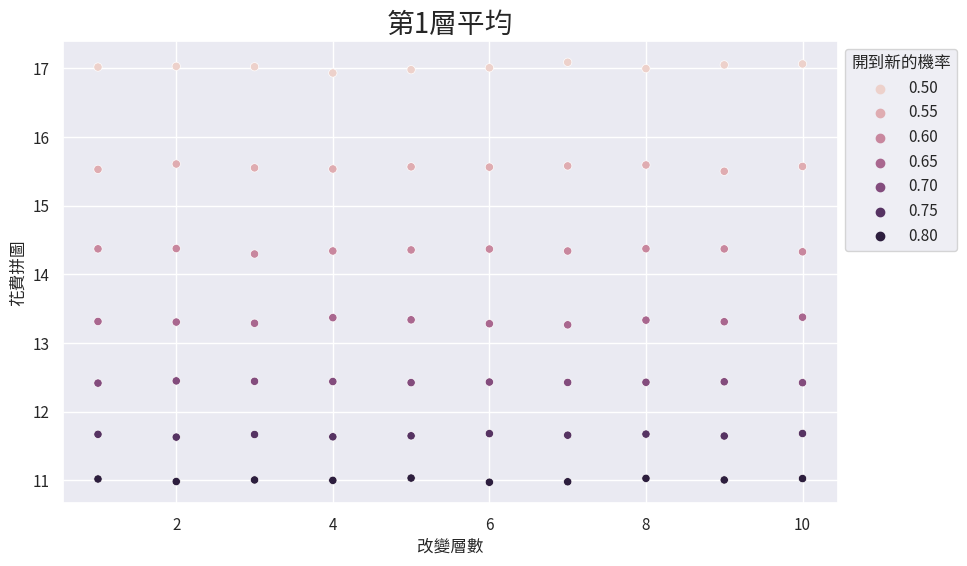

In [47]:
# 繪圖
plt.figure(figsize=(10, 6))
scatter = sns.scatterplot(x = df_results['change_stage'],
                          y = df_results['mean_level_one'],
                          hue = df_results['prob_for_new_holes'],
                          legend = 'full')

scatter.legend(loc='upper left', bbox_to_anchor=(1, 1), title='開到新的機率')

legend_labels = scatter.get_legend().get_texts()
for label in legend_labels:
    label.set_text(f'{float(label.get_text()):.2f}')

plt.title('第1層平均', fontsize=20)
plt.xlabel('改變層數')
plt.ylabel('花費拼圖')

In [48]:
df_results.to_excel('result.xlsx', index=False)

## 4. 新方案 (每層變動機率)
***
第N層前
* 第1層:70%機率開到新的
* 第2層:65%機率開到新的
* 第3層:60%機率開到新的
* 第4層:55%機率開到新的
* 第5層:50%機率開到新的

In [35]:
def new_simulate_holes(change_stage, prob_for_new_holes, drop_prob_step, num_holes = 9, balls_per_hole = 20):
    """定義一個模擬實驗，有9個洞，目標需有20顆球，但前N層會採用K機率開到新的"""
    
    holes = [0] * num_holes        # 初始化9個洞的球數
    num_balls = 0                  # 初始化投球次數
    holes_index = list(range(num_holes))   # 建立一個球洞的index
    recorded_level_one = False
    current_prob = prob_for_new_holes   # 初始化當前機率
    
    # 當關卡 < 改變關卡時，採用初始70%規則，逐層下降
    while min(holes) < change_stage:
        
        # print(f"current_prob:{current_prob}, holes:{holes}")
        
        # 初始化當前層數，最後判斷層數是否變動
        current_stage = min(holes)
        
        # 紀錄最少球的索引
        min_index = [i for i, j in enumerate(holes) if j == min(holes)]   
        
        # 若最少球數索引數量比總洞少，才能進行重複不重複判斷，預防全都一樣小的情形
        if len(min_index) < num_holes:
        
            # 決定新洞還舊洞
            random_prob = random.random()              # 生成一個介於 0 到 1 之間的隨機浮點數
            is_new_hole = 1 if random_prob <= current_prob else 0    # 若骰出浮點數 < 設定值，則選新洞

            # 若新洞
            if is_new_hole == 1:
                hole = random.choice(min_index)         # 從最小洞抽一個

            # 若舊洞    
            else:
                duplicate_holes = [x for x in holes_index if x not in min_index]    # 從非最小洞抽一個
                hole = random.choice(duplicate_holes)
        
        # 若洞的球都一樣多        
        else:
            hole = random.randint(0, num_holes - 1)    # 隨機抽1個洞
        
        holes[hole] += 1                           # 該洞球數 +1
        num_balls += 1  
        
        # 紀錄完成第1層的總投球
        if (not recorded_level_one) & (min(holes) >= 1):
            num_balls_for_level_one = num_balls
            recorded_level_one = True
        

        # 計算下層機率
        if min(holes) > current_stage :    # 若層數有變動，則機率變更
            current_prob += -drop_prob_step
        
        
        
    # 上面迴圈跑完後，才會跑下面迴圈，當任一個洞沒達到目標球數時，繼續投球
    while min(holes) < balls_per_hole:
        hole = random.randint(0, num_holes - 1)    # 隨機抽1個洞
        holes[hole] += 1                           # 該洞球數 +1
        num_balls += 1
        
        # print(f"holes:{holes}")
    
    return num_balls, num_balls_for_level_one

In [38]:
# 進行模擬
num_simulations = 10000
result_list = []
result_level_one = []
for _ in range(num_simulations):
    num_balls, num_balls_for_level_one = new_simulate_holes(change_stage = 10,               # 前5層改變算法機率
                                                            prob_for_new_holes = 0.7,       # 起始機率為70%
                                                            drop_prob_step = 0.06           # 每層下降機率5%
                                                           )
    result_list.append(num_balls)
    result_level_one.append(num_balls_for_level_one)

In [39]:
# 計算結果
df = pd.DataFrame({'20層次數': result_list, '第1層次數': result_level_one})
df.describe()

,20層次數,第1層次數
count,10000.000000,10000.000000
mean,237.378900,12.397100
std,22.733935,2.198703
min,185.000000,9.000000
25%,221.000000,11.000000
50%,234.000000,12.000000
75%,250.000000,14.000000
max,416.000000,24.000000


## 5. 新方案 (每層變動機率)，紀錄每層球數
***
第N層前
* 第1層:70%機率開到新的
* 第2層:65%機率開到新的
* 第3層:60%機率開到新的
* 第4層:55%機率開到新的
* 第5層:50%機率開到新的

In [40]:
def new_simulate_holes(change_stage, prob_for_new_holes, drop_prob_step, num_holes = 9, balls_per_hole = 20):
    """定義一個模擬實驗，有9個洞，目標需有20顆球，但前N層會採用K機率開到新的"""
    
    holes = [0] * num_holes        # 初始化9個洞的球數
    num_balls = 0                  # 初始化投球次數
    holes_index = list(range(num_holes))   # 建立一個球洞的index
    current_prob = prob_for_new_holes   # 初始化當前機率
    balls_used_per_stage = []  # 用來紀錄每一層的花費球數
    
    # 當關卡 < 改變關卡時，採用初始70%規則，逐層下降
    while min(holes) < change_stage:
        
        # print(f"current_prob:{current_prob}, holes:{holes}")
        
        # 初始化當前層數，最後判斷層數是否變動
        current_stage = min(holes)
        
        # 紀錄最少球的索引
        min_index = [i for i, j in enumerate(holes) if j == min(holes)]   
        
        # 若最少球數索引數量比總洞少，才能進行重複不重複判斷，預防全都一樣小的情形
        if len(min_index) < num_holes:
        
            # 決定新洞還舊洞
            random_prob = random.random()              # 生成一個介於 0 到 1 之間的隨機浮點數
            is_new_hole = 1 if random_prob <= current_prob else 0    # 若骰出浮點數 < 設定值，則選新洞

            # 若新洞
            if is_new_hole == 1:
                hole = random.choice(min_index)         # 從最小洞抽一個

            # 若舊洞    
            else:
                duplicate_holes = [x for x in holes_index if x not in min_index]    # 從非最小洞抽一個
                hole = random.choice(duplicate_holes)
        
        # 若洞的球都一樣多        
        else:
            hole = random.randint(0, num_holes - 1)    # 隨機抽1個洞
        
        holes[hole] += 1                           # 該洞球數 +1
        num_balls += 1  
        
        # 紀錄完成第1層的總投球，若投完球後跟一開始投球的層數不等時
        if  (min(holes) != current_stage):
            balls_used_per_stage.append(num_balls)
            # print(balls_used_per_stage)
            

        # 計算下層機率
        if min(holes) > current_stage :    # 若層數有變動，則機率變更
            current_prob += -drop_prob_step
        
        
        
    # 上面迴圈跑完後，才會跑下面迴圈，當任一個洞沒達到目標球數時，繼續投球
    while min(holes) < balls_per_hole:
        
        # 初始化當前層數，最後判斷層數是否變動
        current_stage = min(holes)
        
        hole = random.randint(0, num_holes - 1)    # 隨機抽1個洞
        holes[hole] += 1                           # 該洞球數 +1
        num_balls += 1
        
        # 紀錄完成第1層的總投球，若投完球後跟一開始投球的層數不等時
        if  (min(holes) != current_stage):
            balls_used_per_stage.append(num_balls)
            # print(balls_used_per_stage)
        
        # print(f"holes:{holes}")
    
    return num_balls, balls_used_per_stage

In [41]:
# 進行模擬
num_simulations = 10000
result_list = []
result_all_level = []
for _ in range(num_simulations):
    num_balls, balls_used_per_stage = new_simulate_holes(change_stage = 10,               # 前5層改變算法機率
                                                         prob_for_new_holes = 0.7,       # 起始機率為70%
                                                         drop_prob_step = 0.06           # 每層下降機率5%
                                                        )
    result_list.append(num_balls)
    result_all_level.append(balls_used_per_stage)

In [42]:
# 對每一層進行平均，從0開始
final_level_balls = {}           # 格式 {1:[1,3,1], 2:[6,8,10], 3:[13,16,17],...}
for i in range(len(result_all_level[0])):
    
    # 歷遍每一組結果，將第0層所有結果裝在avg_list
    tmp_list = []
    for j in result_all_level:
        tmp_list.append(j[i])
    
    final_level_balls[i + 1] = tmp_list

In [43]:
# 將字典轉換為 DataFrame
df = pd.DataFrame(list(final_level_balls.items()), columns=['key', 'Values'])
df['avg'] = df['Values'].apply(lambda x:sum(x) / len(x))

In [44]:
df.head()

,key,Values,avg
0,1,"[12, 15, 14, 10, 12, 13, 11, 9, 16, 13, 12, 13...",12.4131
1,2,"[19, 22, 21, 32, 30, 24, 22, 21, 23, 21, 21, 2...",22.7215
2,3,"[32, 37, 33, 36, 35, 32, 31, 30, 32, 32, 30, 3...",33.0916
3,4,"[47, 43, 45, 45, 41, 48, 41, 41, 42, 42, 44, 4...",43.7680
4,5,"[58, 57, 50, 52, 55, 61, 52, 52, 48, 55, 53, 4...",54.6890


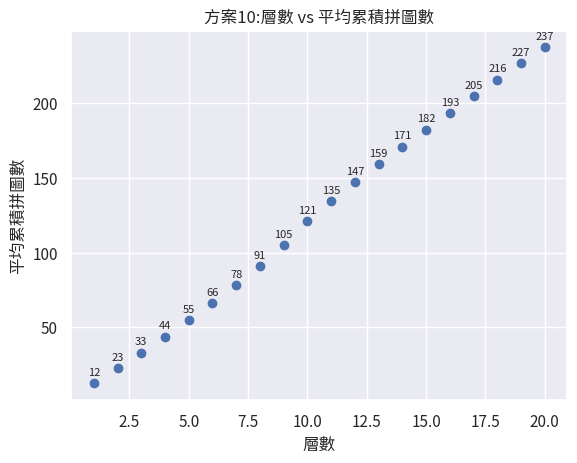

In [45]:
# 繪製 XY 散布圖
plt.scatter(df['key'], df['avg'])
plt.title('方案10:層數 vs 平均累積拼圖數')
plt.xlabel('層數')
plt.ylabel('平均累積拼圖數')

# 在每個點上添加文本標籤
for i, txt in enumerate(df['avg']):
    plt.text(df['key'][i], txt + 4, f'{txt:.0f}', ha='center', va='bottom', fontsize=8)

plt.show()

## 5. 原方案紀錄每層球數
***

In [5]:
def simulate_holes(num_holes = 9, balls_per_hole = 20):
    """定義一個模擬實驗，有9個洞，目標需有20顆球"""
    
    holes = [0] * num_holes     # 初始化9個洞的球數
    num_balls = 0               # 初始化投球次數
    balls_used_per_stage = []  # 用來紀錄每一層的花費球數
    
    # 當任一個洞沒達到目標球數時，繼續投球
    while min(holes) < balls_per_hole:
        
        # 初始化當前層數，最後判斷層數是否變動
        current_stage = min(holes)
        
        hole = random.randint(0, num_holes - 1)    # 隨機抽1個洞
        holes[hole] += 1                           # 該洞球數 +1
        num_balls += 1
        
        # 紀錄完成第1層的總投球，若投完球後跟一開始投球的層數不等時
        if  (min(holes) != current_stage):
            balls_used_per_stage.append(num_balls)
        
    return num_balls, balls_used_per_stage

In [6]:
# 進行模擬
num_simulations = 10000
result_list = []
result_all_level = []
for _ in range(num_simulations):
    num_balls, balls_used_per_stage = simulate_holes()
    result_list.append(num_balls)
    result_all_level.append(balls_used_per_stage)

In [7]:
# 對每一層進行平均，從0開始
final_level_balls = {}           # 格式 {1:[1,3,1], 2:[6,8,10], 3:[13,16,17],...}
for i in range(len(result_all_level[0])):
    
    # 歷遍每一組結果，將第0層所有結果裝在avg_list
    tmp_list = []
    for j in result_all_level:
        tmp_list.append(j[i])
    
    final_level_balls[i + 1] = tmp_list
    
# 將字典轉換為 DataFrame
df = pd.DataFrame(list(final_level_balls.items()), columns=['key', 'Values'])
df['avg'] = df['Values'].apply(lambda x:sum(x) / len(x))

In [8]:
df.head()

,key,Values,avg
0,1,"[50, 27, 16, 18, 20, 26, 29, 12, 26, 26, 38, 2...",25.3210
1,2,"[58, 37, 39, 49, 27, 47, 39, 48, 30, 39, 39, 3...",40.5345
2,3,"[59, 52, 52, 60, 38, 50, 54, 51, 46, 49, 50, 4...",54.0235
3,4,"[67, 77, 60, 67, 95, 60, 61, 52, 50, 59, 63, 4...",66.6536
4,5,"[95, 97, 63, 70, 104, 81, 88, 109, 55, 74, 71,...",78.8759


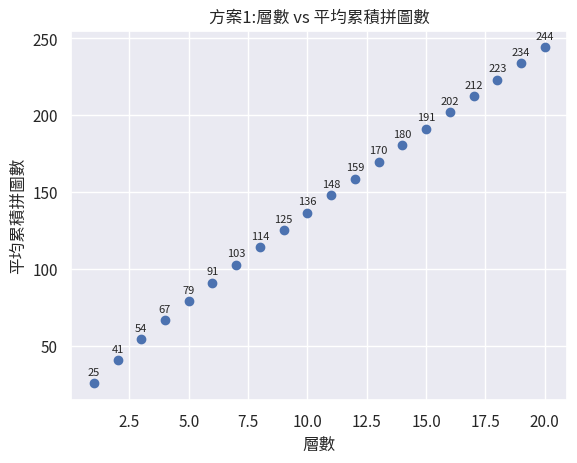

In [10]:
# 繪製 XY 散布圖
plt.scatter(df['key'], df['avg'])
plt.title('方案1:層數 vs 平均累積拼圖數')
plt.xlabel('層數')
plt.ylabel('平均累積拼圖數')

# 在每個點上添加文本標籤
for i, txt in enumerate(df['avg']):
    plt.text(df['key'][i], txt + 4, f'{txt:.0f}', ha='center', va='bottom', fontsize=8)

plt.show()